---
# **振動情報処理特論　第1回レポート**
## **Pythonによる離散フーリエ変換とその周辺技術の確認**
---

### 1. エイリアシングの確認
連続信号のサンプリングに伴うエイリアシングについて，実際にこれが起こる実例について波形を示し，理論的に得られるであろう結果と比較して論ぜよ．

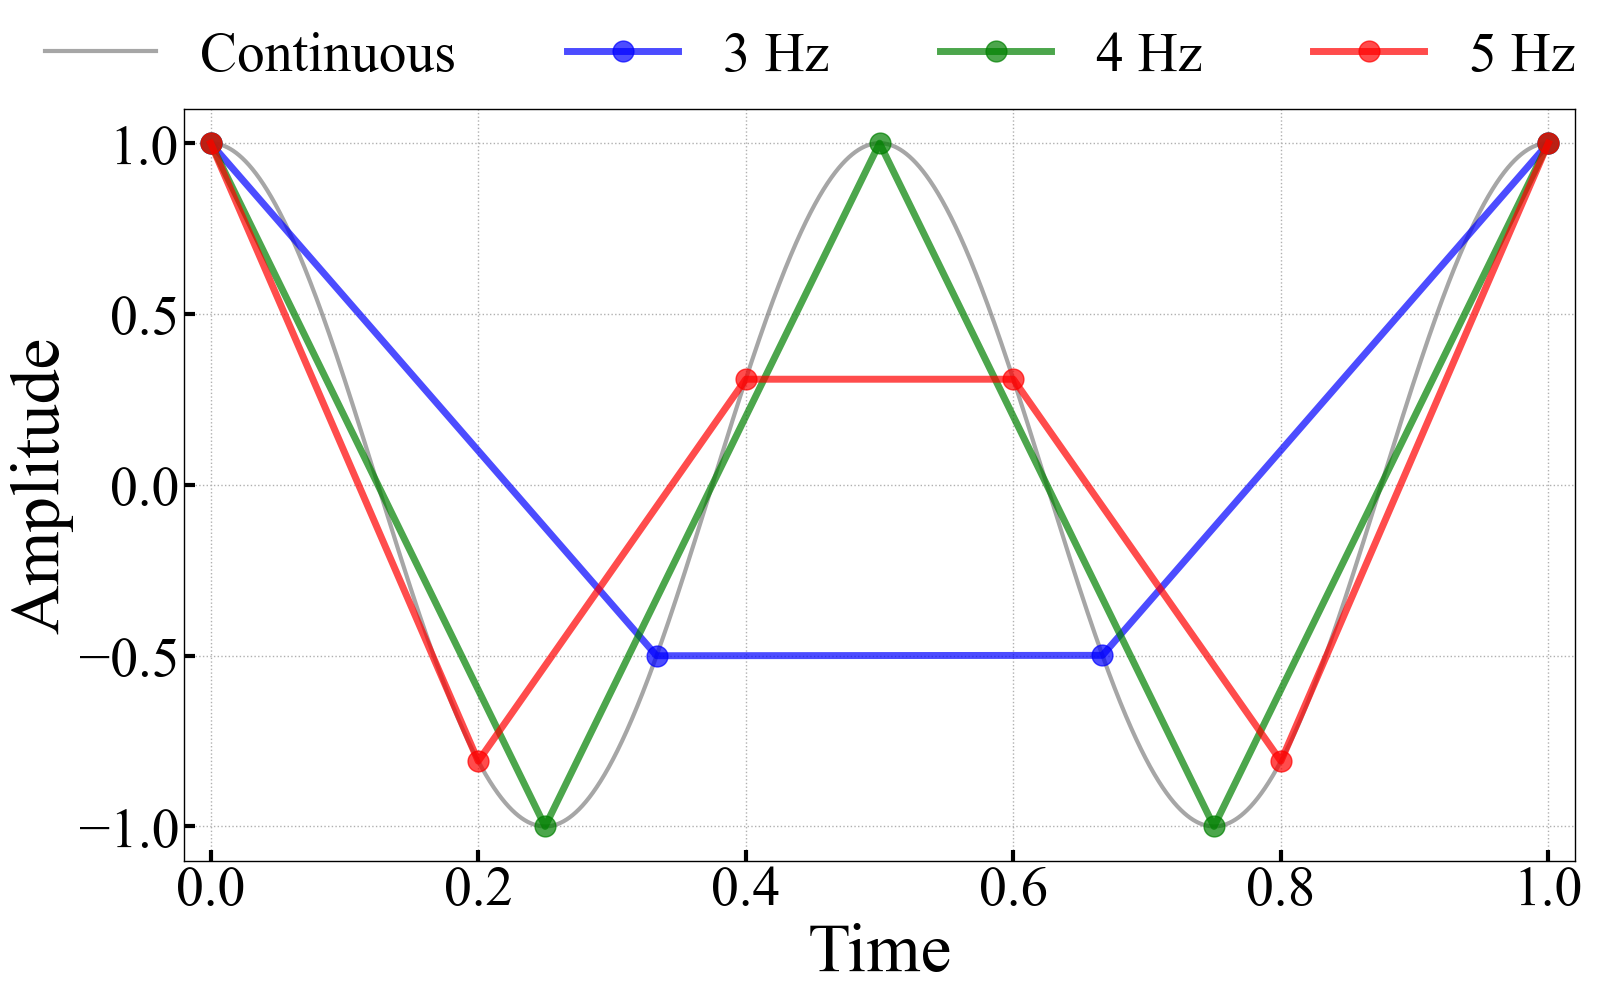

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configure figure infomation
params = {
    'figure.autolayout':True,                    # Auto layout
    'font.family':'Times New Roman',#'Arial',    # Font setting
    'pdf.fonttype':42,                           # PDF font type
    'axes.linewidth':1.0,                        # Linewidth of axes
    'patch.linewidth':1.0,                       # Linewidth of legend
    'grid.linewidth':1.0,                        # Linewidth of grid
    'axes.labelsize':50,                         # Font size of axes label
    'font.size':8,                               # Text size　　　　　　
    'legend.fontsize':70,                        # Font size of legend
    'xtick.labelsize':40,                        # Font size of values in x axes
    'ytick.labelsize':40,                        # Font size of values in x axes
    'text.usetex':False,                         # For TeX font -> True
    'figure.figsize':[16, 9]#[8/2.54, 6/2.54]    # Output size (inch order)
}
rcParams.update(params)


# Signal setting
t = np.linspace(0, 1, 10**4, endpoint=False)
signal = np.cos(2 * np.pi * 2 * t)


# Sampling
sampling_rates = [3, 4, 5]
sampled_signals = []
sampled_times = []

for samp in sampling_rates:
    samples = []
    sample_times = []
    for n in np.linspace(0, 1, int(samp) + 1, endpoint=True):
        idx = min(int(n * len(t)), len(t) - 1)
        sample_times.append(t[idx])
        samples.append(signal[idx])
    sampled_times.append(sample_times)
    sampled_signals.append(samples)


# Draw graphs
fig, ax = plt.subplots(1, 1)

ax.plot(t, signal, marker='', color='gray', zorder=1, linewidth=3.0, alpha=0.7, label="Continuous")
color = ['blue', 'green', 'red']
for i, (samp_time, samp_signal, samp) in enumerate(zip(sampled_times, sampled_signals, sampling_rates)):
    ax.plot(samp_time, samp_signal, color=color[i], linewidth=5.0, label=f"{samp} Hz", marker='o', markersize=15, alpha=0.7)

ax.set_xlabel('Time', fontname="Times New Roman")
ax.set_ylabel('Amplitude', fontname="Times New Roman")

ax.set_xticks(np.arange(0, 1.5, 0.2))
ax.set_yticks(np.arange(-1.0, 1.5, 0.5))

ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-1.1, 1.1)

ax.grid(linestyle='dotted', linewidth=1)
ax.set_axisbelow(True)

ax.xaxis.set_tick_params(which='major', width=3.0, direction='in', bottom=True, top=False, length=8)
ax.yaxis.set_tick_params(which='major', width=3.0, direction='in', left=True, right=False, length=8)

plt.tight_layout()
ax.legend(prop={"family":"Times New Roman", "size":40}, bbox_to_anchor=(0.45, 1.17), loc='upper center', frameon=False, shadow=True, ncol=4, fancybox=False, edgecolor='black')
plt.show()


　今回は，0秒から1秒の間で2Hzの余弦関数を，3Hz, 4Hz, 5Hzでそれぞれサンプリングすることを行った．したがって，サンプリング前の波形は以下のように表せる．
$$
x(t) = \cos {(4 \pi t)}
$$
　サンプリング定理によれば，ナイキスト周波数（：サンプリング周波数の半分）を超える信号に対するサンプリングではエイリアシング（：異なる周波数の同士の信号との区別ができなくなり正しく周波数を特定できなくなること）が発生する．したがって，今回は信号に含まれる2Hzの成分が正しくサンプリングされればよいため，エイリアシングを発生させないためにはナイキスト周波数は2Hz以上である必要があり，サンプリング周波数はその2倍の4Hz以上である必要がある．今回はエイリアシングの影響を確認するために，その条件を十分に満たす5Hz，取得したい周波数がナイキスト周波数と等しくなる4Hz，条件を満たさない3Hzの3つの場合でサンプリングを行った．  
　理論的には，サンプリング定理を満たす5Hz，4Hzでサンプリングを行った場合の波形は2Hzの波形を示すはずであり，3Hzの波形のみエイリアシングの影響で波形が折り返されたように描画されるはずである．今回描画したグラフを確認すると，理論通りの結果が得られていることが確認できる．特に，3Hzの場合は実波形のピークから次のピークまでのサンプリングが粗すぎて（遅すぎて）その変動を正しくサンプリングできていないことが確認できる．これによって，波形としては折り返しすなわちエイリアシングが起きているということが視覚的に確認できた．  
　ただし，4Hzの（取得したい周波数がナイキスト周波数と等しくなる）場合には注意が必要である．今回は極大と極小を交互にサンプリングしているため，丁度良くサンプリングされたと考えることもできるが，実波形がこれと4分の1周期ずれていた場合を考えると，サンプリングされる点はすべて0で一定となってしまう．したがって，どのような場合でも正しく周波数成分を取得するためには，サンプリング周波数をその周波数成分の2倍よりも大きく取る必要があると考えられる．

### 2. 離散信号に対する離散フーリエ変換の実行
$N=16$点の離散信号に対し，離散フーリエ変換を行うプログラムを書き，作成したソースコードを示せ．次に，このプログラムに対する入出力の例を示し，得られた結果について論ぜよ．なお，フーリエ変換の意味が良くわかるような入出力例を適切に選択すること．

x_n = [ 1.5         1.64065228  1.91421356  1.97247365  1.5         0.44173992
 -0.91421356 -2.05486585 -2.5        -2.05486585 -0.91421356  0.44173992
  1.5         1.97247365  1.91421356  1.64065228]
X_m = [(8+0j), (16-0j), (-8+0j), 0j, (-0-0j), (-0+0j), (-0+0j), (-0+0j), -0j, (-0-0j), -0j, -0j, 0j, (-0+0j), (-8-0j), (16+0j)]


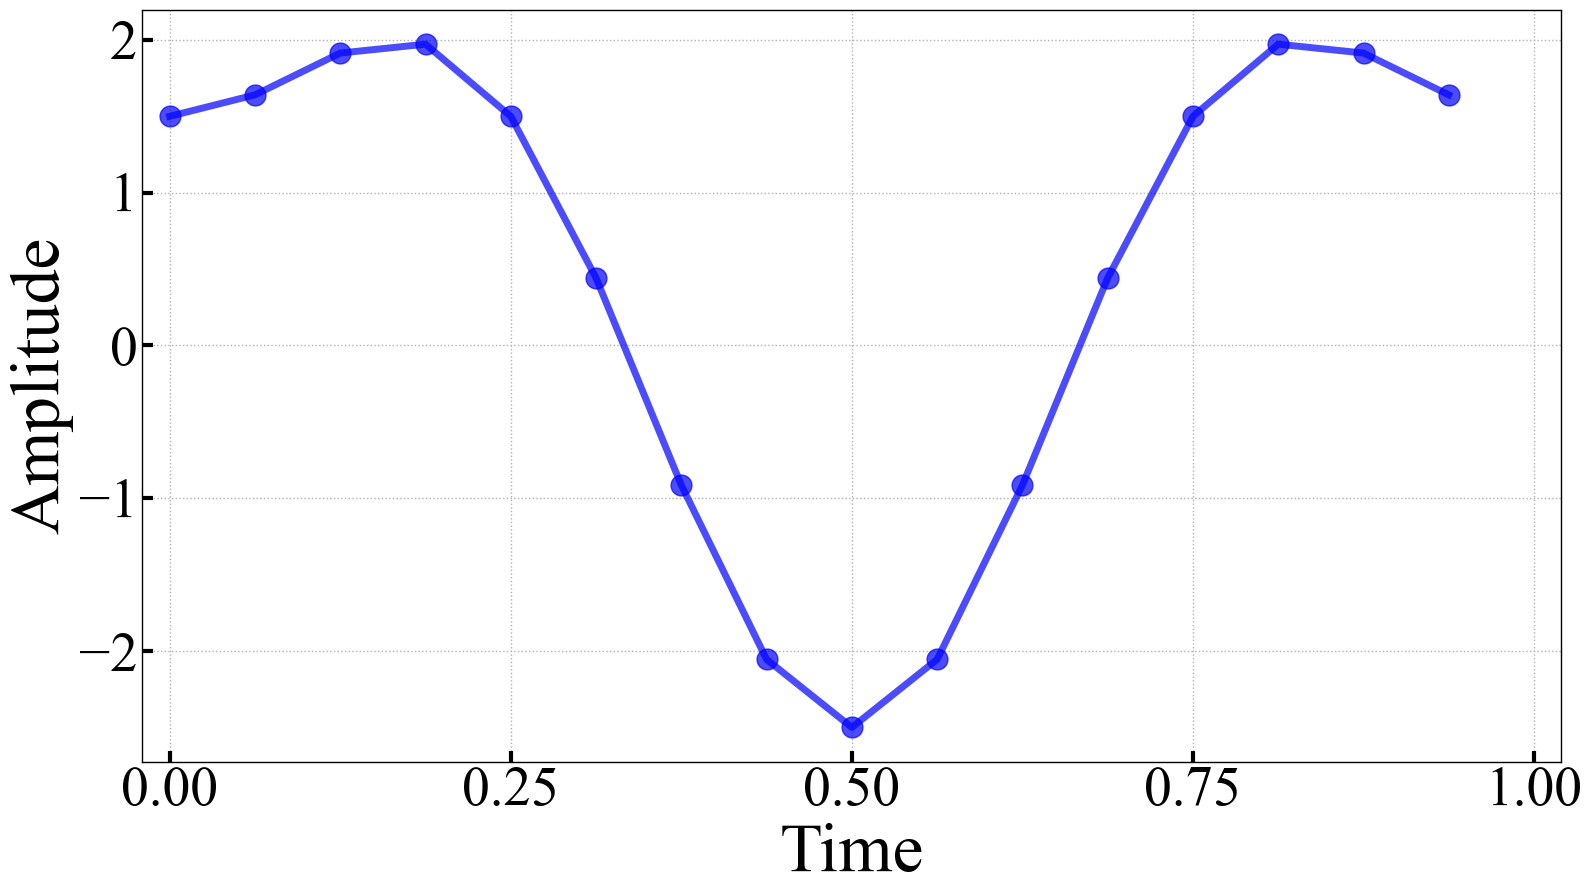

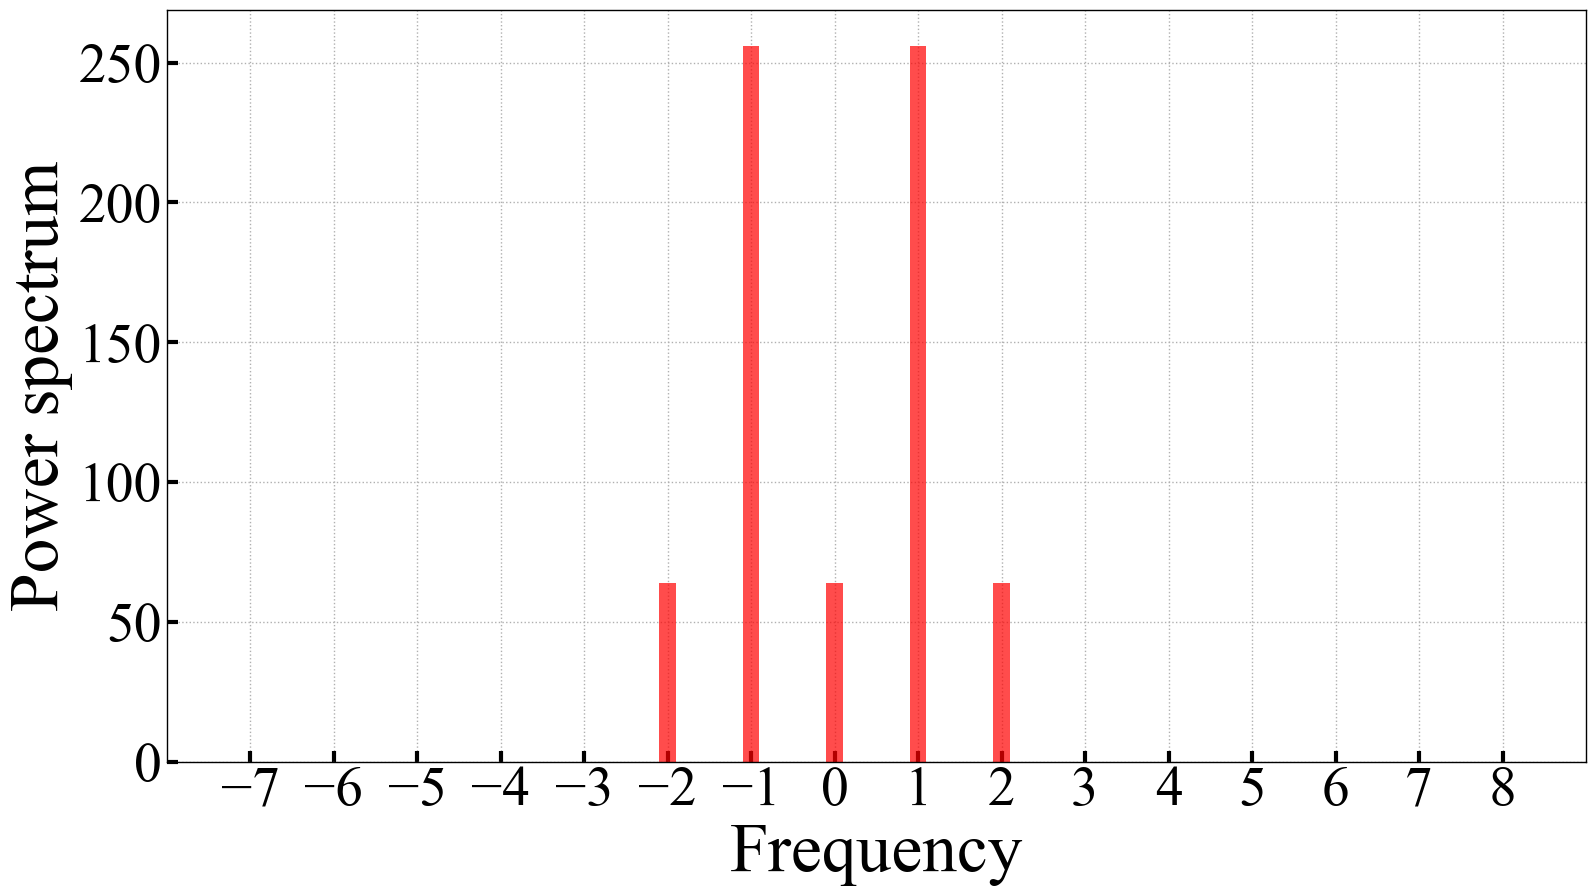

In [ ]:
# Functions for the digital Fourier transform
def fourier_transform(signal):
    N = len(signal)
    spectrum = []
    for m in range(N):
        X_m = 0
        for n in range(N):
            # Floating-point rounding errors are included
            X_m += np.exp(-1j * 2 * np.pi * m * n / N) * signal[n]
        # Canceling the effects of floating-point rounding errors
        spectrum.append(np.round(X_m, 10))
    return spectrum


# Digital Fourier transform of the sampled signal
N = 16
t_samp = np.linspace(0, 1, N, endpoint=False)
input = 2 * np.cos(2 * np.pi * 1 * t_samp) - np.cos(2 * np.pi * 2 * t_samp) + 0.5
output = fourier_transform(input)
print(f'x_n = {input}')
print(f'X_m = {output}')


# Draw input graphs
fig, ax = plt.subplots(1, 1)

ax.plot(t_samp, input, marker='o', markersize=15, color='blue', zorder=1, linewidth=5.0, alpha=0.7)

ax.set_xlabel('Time', fontname="Times New Roman")
ax.set_ylabel('Amplitude', fontname="Times New Roman")

ax.set_xticks(np.arange(0, 1.5, 0.25))

ax.set_xlim(-0.02, 1.02)

ax.grid(linestyle='dotted', linewidth=1)
ax.set_axisbelow(True)

ax.xaxis.set_tick_params(which='major', width=3.0, direction='in', bottom=True, top=False, length=8)
ax.yaxis.set_tick_params(which='major', width=3.0, direction='in', left=True, right=False, length=8)

plt.tight_layout()
plt.show()


# Draw output graphs
fig, ax = plt.subplots(1, 1)

label = []
power = []
M = len(output)
for i in range(0, M):
    if i > M / 2:
        label.append((i - M) / (M / N))
    else:
        label.append(i / (M / N))
    power.append(output[i].real ** 2 + output[i].imag ** 2)

ax.bar(label, power, color='red', alpha=0.7, width=0.2)

ax.set_xlabel('Frequency', fontname="Times New Roman")
ax.set_ylabel('Power spectrum', fontname="Times New Roman")

ax.set_xticks(np.arange(-N // 2 + 1, N // 2 + 1))
ax.set_xlim(-N // 2, N // 2 + 1)

ax.grid(linestyle='dotted', linewidth=1)
ax.set_axisbelow(True)

ax.xaxis.set_tick_params(which='major', width=3.0, direction='in', bottom=True, top=False, length=8)
ax.yaxis.set_tick_params(which='major', width=3.0, direction='in', left=True, right=False, length=8)

plt.tight_layout()
plt.show()

　今回は入力関数$x(t)$を以下のように設定した．
$$
x(t) = 2 \cos {(2 \pi t)} - \cos {(4 \pi t)} + 0.5
$$
この信号を時刻0秒から1秒に対して16等分（サンプリング）し，$n$番目にサンプリングされた信号を$x_n$と表す．プログラム上では，以下のようなベクトルとして入力した．
$$
x_n = [ 1.50, 1.64, 1.91, 1.97, 1.50, 0.44, -0.91, -2.05, -2.50, -2.05, -0.91, 0.44, 1.50, 1.97, 1.91, 1.64]
$$  
　離散フーリエ変換を行う関数を作成し，その結果（周波数成分に関するベクトル）を出力可能とした．ただし，この関数内では信号をfloat型で扱うことによる浮動小数点丸め誤差が生じ理論的に得られる結果とずれがあるため，このずれが小数第10位のオーダで収まると仮定し四捨五入を行った．この関数に$x_n$を入力することによって得られる出力ベクトル$X_m$を以下に示す．
$$
X_m = [8, 16, -8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -8, 16]
$$
元の離散信号$x_n$に含まれる周波数成分は0Hz，1Hz，2Hzであるといえる．一方で，出力ベクトルは0Hzに8，1Hzに16，2Hzに-8というベクトルを持つ．この結果より，ベクトルの各成分が複素数でありその絶対値の比が信号に含まれる波形の周波数成分の振幅，偏角が位相を意味することから，含まれるべき周波数成分を正しく特定できていることが確認できる．加えて，14Hzに-8，15Hzに16と必要のない周波数が取得されているようにも見えるが，今回は1秒に対して16回サンプリングしているため，ナイキスト周波数はその半分の8Hzとなり，それ以上の周波数に対応するベクトルは，循環畳み込みの影響から負の周波数を意味する．したがって，-2Hzに-8，-1Hzに16というベクトルを持つことが示され，実信号$x_n$を複素正弦波で表すための負の周波数成分も正しく現れていることが確認できる．  
　加えて，パワースペクトルのグラフでも-2，-1，0，1，2Hzでスペクトルが確認でき，前述の内容と同様のことが確認できる．パワースペクトルの値に関しては$X_m$の成分（複素数）の2乗であるため，振幅の大きい波形の成分がより目立つように描画されることが確認できる．

### 3. ゼロ詰めによる影響の確認
$N=16$点の離散信号のうち非周期的な正弦波信号に対し，窓かけを行った場合とそうでない場合について2．のソースコードでパワースペクトルを求めた結果について示せ（ソースコードは示さなくてよい）．また，窓かけ後の信号に対し，$N=64$となるようゼロ詰めを行った場合のパワースペクトルについても併せて示し，それぞれ得られた結果について論ぜよ．

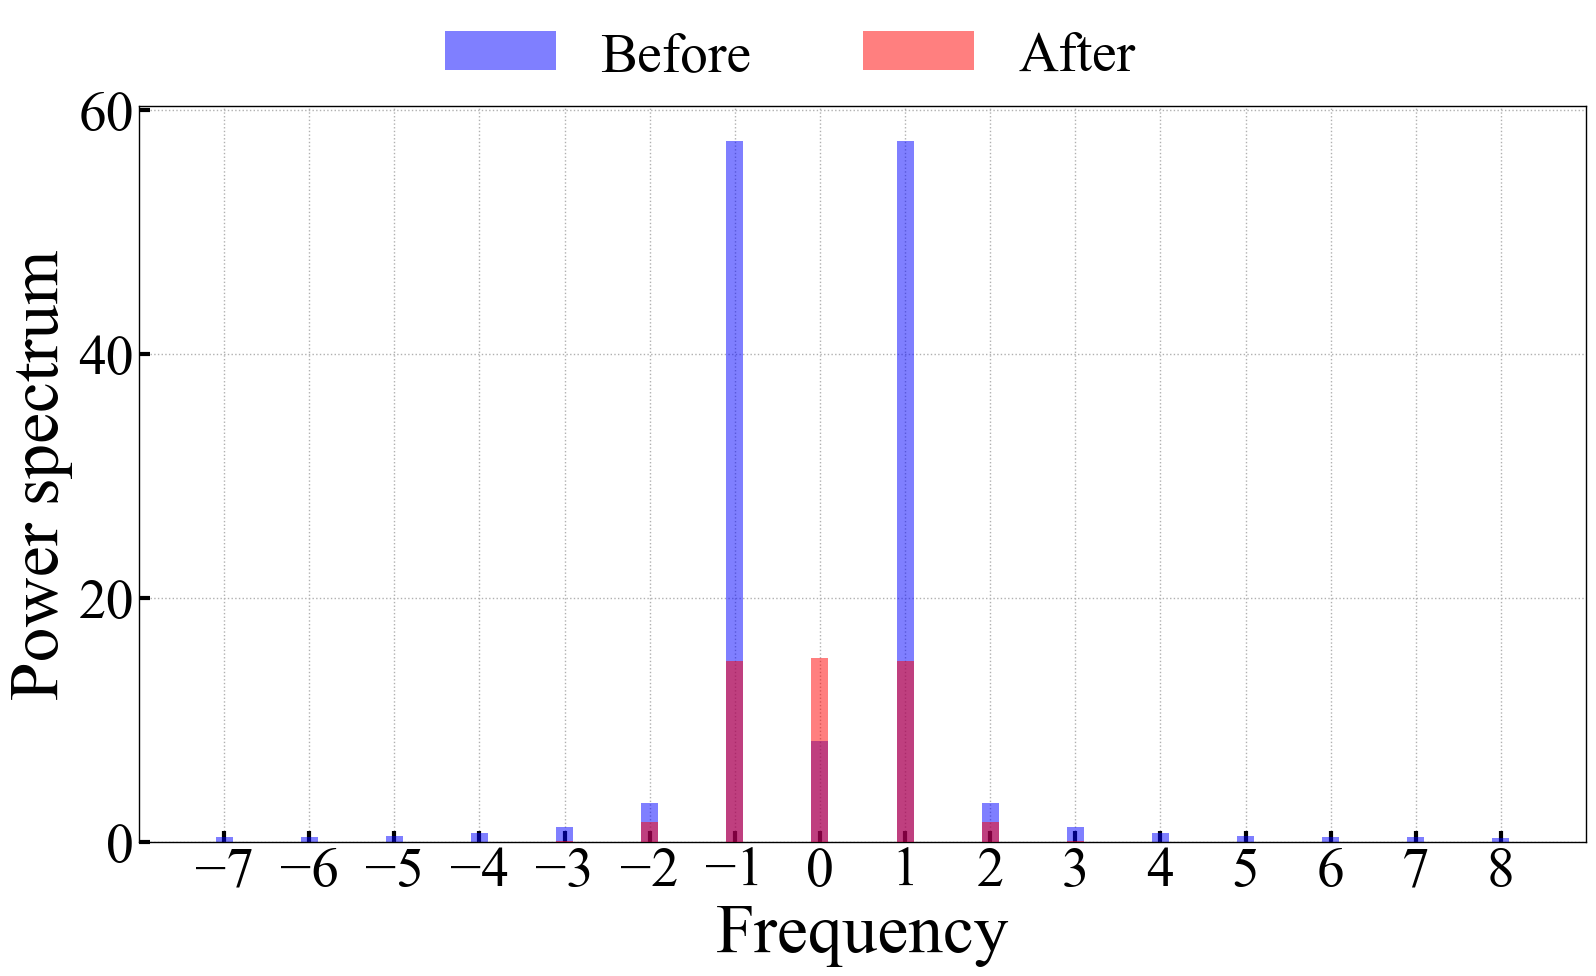

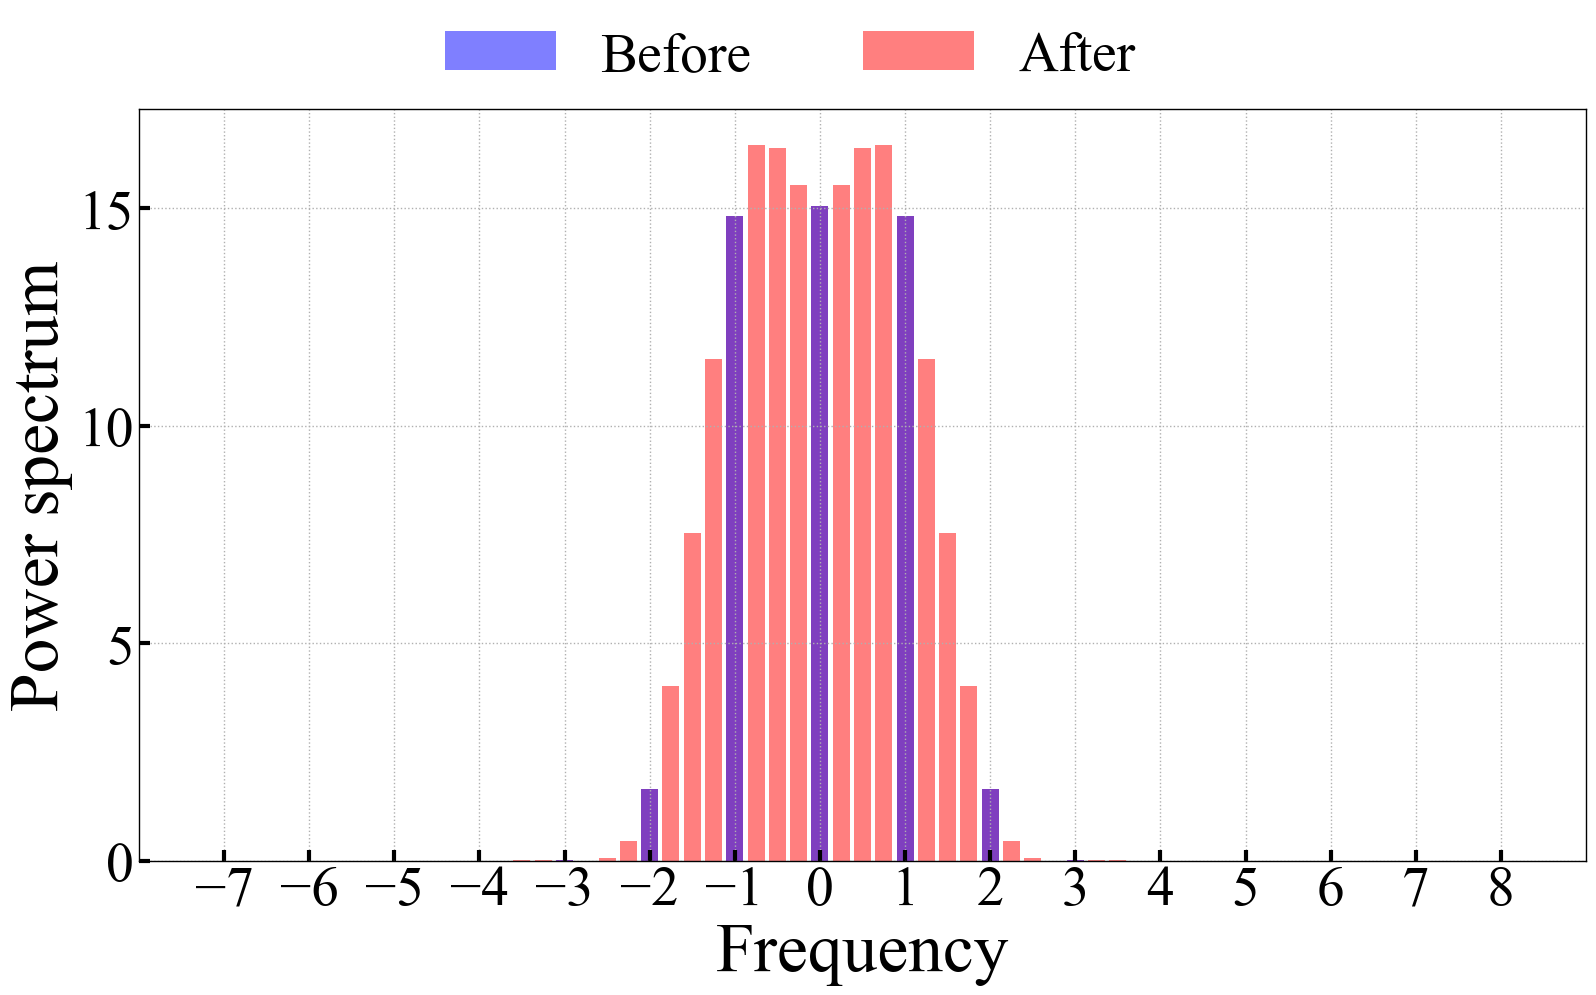

In [9]:
# Aperiodic signal setting
N = 16
t_samp = np.linspace(0, 1, N, endpoint=False)
signal_aperiodic = np.cos(2 * np.pi * 0.75 * t_samp)

# Window function setting
window = 0.5 * (1 - np.cos(2 * np.pi * t_samp))
signal_window = signal_aperiodic * window

# Zero padding
_N = 64
signal_padding = np.append(signal_window, [0] * (_N - N))


# Fourier transform
spectrum_nomal = fourier_transform(signal_aperiodic)
spectrum_window = fourier_transform(signal_window)
spectrum_padding = fourier_transform(signal_padding)


# Draw graphs of the effect of window covering
fig, ax = plt.subplots(1, 1)

zorder = 1
for output, title, color in zip([spectrum_nomal, spectrum_window], ['Before', 'After'], ['blue', 'red']):
    label = []
    power = []
    M = len(output)
    for i in range(0, M):
        if i > M / 2:
            label.append((i - M) / (M / N))
        else:
            label.append(i / (M / N))
        power.append(output[i].real ** 2 + output[i].imag ** 2)

    zorder += 1
    ax.bar(label, power, color=color, alpha=0.5, width=0.2, label=title, zorder=zorder)

ax.set_xlabel('Frequency', fontname="Times New Roman")
ax.set_ylabel('Power spectrum', fontname="Times New Roman")

ax.set_xticks(np.arange(-N // 2 + 1, N // 2 + 1))
ax.set_xlim(-N // 2, N // 2 + 1)

ax.grid(linestyle='dotted', linewidth=1)
ax.set_axisbelow(True)

ax.xaxis.set_tick_params(which='major', width=3.0, direction='in', bottom=True, top=False, length=8)
ax.yaxis.set_tick_params(which='major', width=3.0, direction='in', left=True, right=False, length=8)

plt.tight_layout()
ax.legend(prop={"family":"Times New Roman", "size":40}, bbox_to_anchor=(0.45, 1.17), loc='upper center', frameon=False, shadow=True, ncol=4, fancybox=False, edgecolor='black')
plt.show()


# Draw graphs of the effect of zero padding
fig, ax = plt.subplots(1, 1)

zorder = 1
for output, title, color in zip([spectrum_window, spectrum_padding], ['Before', 'After'], ['blue', 'red']):
    label = []
    power = []
    M = len(output)
    for i in range(0, M):
        if i > M / 2:
            label.append((i - M) / (M / N))
        else:
            label.append(i / (M / N))
        power.append(output[i].real ** 2 + output[i].imag ** 2)

    zorder -= 1
    ax.bar(label, power, color=color, alpha=0.5, width=0.2, label=title, zorder=zorder)

ax.set_xlabel('Frequency', fontname="Times New Roman")
ax.set_ylabel('Power spectrum', fontname="Times New Roman")

ax.set_xticks(np.arange(-N // 2 + 1, N // 2 + 1))
ax.set_xlim(-N // 2, N // 2 + 1)

ax.grid(linestyle='dotted', linewidth=1)
ax.set_axisbelow(True)

ax.xaxis.set_tick_params(which='major', width=3.0, direction='in', bottom=True, top=False, length=8)
ax.yaxis.set_tick_params(which='major', width=3.0, direction='in', left=True, right=False, length=8)

plt.tight_layout()
ax.legend(prop={"family":"Times New Roman", "size":40}, bbox_to_anchor=(0.45, 1.17), loc='upper center', frameon=False, shadow=True, ncol=4, fancybox=False, edgecolor='black')
plt.show()

　まず，正弦波信号$x(t)$を以下のように定義した．
$$
x(t) = \sin {(2 \pi \frac {3} {4} t)}
$$
これを0秒から1秒の範囲で$N=16$点サンプリングすることによって非周期的な離散信号$x_n$とした．
$$
x_n = \sin {(\frac {3 \pi n} {2 N})}
$$
前者のグラフはこの信号に対して窓かけを行った場合とそうでない場合について離散フーリエ変換を行い，パワースペクトルを求めた結果である．窓関数$w_n$には以下に示すようなハン窓（ハニング窓）を用いた．
$$
w_n = \frac {1} {2} (1 - \cos {(\frac {2 \pi n} {N})})
$$
理論的には，0秒から1秒の範囲をサンプリングしているため，周波数に関する分解能は1Hzが限度であり，その整数倍の周波数でのみ表現可能であるから，実信号に含まれる0.75Hzは取得できず，その他の周波数成分の組み合わせで表現するために，広範囲の周波数を要することが予測される．グラフより，窓かけを行う前では0.75Hz付近の周波数のパワースペクトルが大きく，その他の広い範囲にもスペクトルが存在していることが確認でき，窓かけ後のスペクトルは0.75Hzから遠い成分が除去され，0Hzを除く全体のパワーが小さくなっていることが確認できた．ハン窓のフーリエ変換に関しては，[こちら](https://www.allisone.co.jp/html/Notes/Mathematics/Fourier/window-function/index.html)を参考にすれば，0Hzで0.5のピークをとり，周辺に末広がりな形状をとり，さらにそれよりも外の周波数では0に近くなるような関数となることがわかる．窓かけ（窓関数$w_n$を信号$x_n$に掛け算すること）の影響が，フーリエ変換後では信号のフーリエ変換$X_m$が窓関数のフーリエ変換$W_m$の畳み込みを意味することを考えれば，ハン窓のフーリエ変換が0Hzから遠い周波数で0に近い値となることが，信号の不要な高周波成分を除去したと捉えることができる．したがって，窓関数が信号にかけられることによってスペクトルもぼやかされ，本来捉えられるべきではない周波数成分を除去する（限りなく小さくする）効果があることが確認できた．  
　後者のグラフは窓かけ後の信号に対し$N=64$となるようゼロ詰めを行う前後におけるパワースペクトルの比較を表したものである．理論的には，0秒から1秒の間のデータが4倍となったことにより分解能も4倍となり，周波数の最小単位は4分の1の0.25Hzとなることが考えられる．実際に，これと同様のことがグラフからも確認できる．また，分解能が上がった部分のパワースペクトルの値は元からわかっていた周波数成分の間を連続的に埋めるような値を取っていることが確認できる．また，分解能が上がったことによって0.75Hzがスペクトルのピークとなっていることが確認でき，正しい周波数成分が得られるように改善されたことが確認できる．ただし，この改善はどのような場合でも起こるわけではなく，分解能が上がったからといって本来含まれるべきであった周波数Hzが必ずしも正しく得られるわけではないことには注意が必要である．したがって，ゼロ詰めによって見かけ上の周波数分解能が向上する効果があることが確認できた．

### 感想  
　学部3年で機械学習（深層学習）による画像生成に興味を持ち，画像処理の奥深さに苦戦した．画像は2次元の信号であると捉えることができ，信号処理（振動処理）についても知見が必要であると感じ勉強するに至ったが，信号処理も非常に奥が深いと感じ苦戦した．これらの理論を完璧にさらい，理想の処理・モデル・解析が行えるようになる必要があると感じた．